

---


# **Combination of Dataframes and ML prediction**
#### ***Look before you Leap : Leveraging Predictive Models to Improve Automotive Safety and Travel Time***



---



**Final Project**
CSCI 35300/79502   |   Fall 2020 

##### Hannah Do







In [3]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import datetime, string, re
import sys, os

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from collections import Counter

print('All Libraries Sucessfully Imported')

All Libraries Sucessfully Imported


---
### Merging dataframes - traffic + tweet
- Importing previously saved csv files

In [36]:
traffic = pd.read_csv("data_traffic/accident_Jun_2020.csv", index_col= None, header = None)
tweet = pd.read_csv("data_twitter/locat_6a.csv", index_col= None, header = None)

traffic = traffic.drop([0], axis=1)
tweet = tweet.drop([0], axis=1)

# drop NaN column with index values

traffic.columns = traffic.iloc[0]
traffic = traffic[1:] 
tweet.columns = tweet.iloc[0]
tweet = tweet[1:] 
# make first row as column names
    


In [56]:

tweet['longitude'] = tweet['longitude'].apply(lambda x: float(x))
tweet['latitude'] = tweet['latitude'].apply(lambda x: float(x))
traffic['LONGITUDE'] = traffic['LONGITUDE'].apply(lambda x: float(x))
traffic['LATITUDE'] = traffic['LATITUDE'].apply(lambda x: float(x))

# tweet['long_index'].round(decimals=5)
# tweet['lat_index'].round(decimals=5)
# traffic['long_index'].round(decimals=5)
# traffic['lat_index'].round(decimals=5)
traffic

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,long_index,lat_index,distance,severity
1,2020-06-30,11:00,NaN,NaN,40.607243,-73.987260,"(40.607243, -73.98726)",AVENUE P,NaN,0,...,0,Unspecified,NaN,4324995,Station Wagon/Sport Utility Vehicle,NaN,-73.987260,40.607243,10000,0
2,2020-06-30,15:40,NaN,NaN,40.782787,-73.957410,"(40.782787, -73.95741)",EAST 89 STREET,NaN,0,...,0,Unspecified,NaN,4324800,Station Wagon/Sport Utility Vehicle,NaN,-73.957410,40.782787,10000,0
3,2020-06-28,14:30,NaN,NaN,40.707860,-73.848460,"(40.70786, -73.84846)",JACKIE ROBINSON PKWY,NaN,1,...,0,Following Too Closely,Unspecified,4323925,Sedan,Sedan,-73.848460,40.707860,10000,0
4,2020-06-27,19:20,BROOKLYN,11210,40.628730,-73.943340,"(40.62873, -73.94334)",EAST 34 STREET,FLATBUSH AVENUE,0,...,0,Driver Inattention/Distraction,Unspecified,4326375,Sedan,Sedan,-73.943340,40.628730,10000,0
5,2020-06-25,14:00,NaN,NaN,40.757725,-73.779274,"(40.757725, -73.779274)",204 STREET,NaN,0,...,0,Backing Unsafely,Unspecified,4323080,Sedan,Sedan,-73.779274,40.757725,10000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,2020-06-18,13:52,BRONX,10468.0,40.867680,-73.894660,"(40.86768, -73.89466)",NaN,NaN,1,...,0,Backing Unsafely,NaN,4321533,Sedan,NaN,-73.894660,40.867680,10000,0
6841,2020-06-11,17:20,MANHATTAN,10034.0,40.862410,-73.922500,"(40.86241, -73.9225)",NAGLE AVENUE,ACADEMY STREET,0,...,0,Driver Inattention/Distraction,NaN,4319426,Station Wagon/Sport Utility Vehicle,NaN,-73.922500,40.862410,10000,0
6842,2020-06-06,0:05,NaN,NaN,40.833010,-73.950270,"(40.83301, -73.95027)",HENRY HUDSON PARKWAY,NaN,0,...,0,Pavement Slippery,NaN,4318296,Sedan,NaN,-73.950270,40.833010,10000,0
6843,2020-06-22,4:10,NaN,NaN,40.903480,-73.850350,"(40.90348, -73.85035)",WHITE PLAINS ROAD,NaN,1,...,0,Unspecified,NaN,4322453,Sedan,NaN,-73.850350,40.903480,10000,0


In [59]:
# temp2 = temp2.reset_index(drop=True)

freq2 = pd.DataFrame()
freq2 = tweet.groupby(["longitude", "latitude"]).size().reset_index(name="Frequency")

freq2 = freq2.sort_values('Frequency', ascending=False)

freq2.drop(freq2.head(15).index,inplace=True)
# most frequent value is the default value that returns location of 'new york'

freq2[['polar score', 'neutral score']] = tweet[['polar score', 'neutral score']]

freq2 = freq2.reset_index(drop=True)


In [70]:
traffic['distance'] = 10000
traffic['severity'] = 0

for i in range(len(traffic['LONGITUDE'])-1):
    for j in range(len(freq2['longitude'])-1):
        x = (np.sqrt(((traffic['LONGITUDE'][i+1]-freq2['longitude'][j+1])*100000)**2 + ((traffic['LATITUDE'][i+1]-freq2['latitude'][j+1])*100000)**2))
        if (x < 3500):
            traffic['severity'][i+1] += 1
            if (traffic['distance'][i+1] > x):
                
                
#                 pd.Series([False, False]).any()

                traffic['distance'] = x
            else:
                pass
        else:
            pass



<ipython-input-70-2e1203ee3d46>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic['severity'][i+1] += 1


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,long_index,lat_index,distance,severity
1,2020-06-30,11:00,NaN,NaN,40.607243,-73.987260,"(40.607243, -73.98726)",AVENUE P,NaN,0,...,0,Unspecified,NaN,4324995,Station Wagon/Sport Utility Vehicle,NaN,-73.987260,40.607243,0.44908,28
2,2020-06-30,15:40,NaN,NaN,40.782787,-73.957410,"(40.782787, -73.95741)",EAST 89 STREET,NaN,0,...,0,Unspecified,NaN,4324800,Station Wagon/Sport Utility Vehicle,NaN,-73.957410,40.782787,0.44908,97
3,2020-06-28,14:30,NaN,NaN,40.707860,-73.848460,"(40.70786, -73.84846)",JACKIE ROBINSON PKWY,NaN,1,...,0,Following Too Closely,Unspecified,4323925,Sedan,Sedan,-73.848460,40.707860,0.44908,28
4,2020-06-27,19:20,BROOKLYN,11210,40.628730,-73.943340,"(40.62873, -73.94334)",EAST 34 STREET,FLATBUSH AVENUE,0,...,0,Driver Inattention/Distraction,Unspecified,4326375,Sedan,Sedan,-73.943340,40.628730,0.44908,29
5,2020-06-25,14:00,NaN,NaN,40.757725,-73.779274,"(40.757725, -73.779274)",204 STREET,NaN,0,...,0,Backing Unsafely,Unspecified,4323080,Sedan,Sedan,-73.779274,40.757725,0.44908,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,2020-06-18,13:52,BRONX,10468.0,40.867680,-73.894660,"(40.86768, -73.89466)",NaN,NaN,1,...,0,Backing Unsafely,NaN,4321533,Sedan,NaN,-73.894660,40.867680,0.44908,44
6841,2020-06-11,17:20,MANHATTAN,10034.0,40.862410,-73.922500,"(40.86241, -73.9225)",NAGLE AVENUE,ACADEMY STREET,0,...,0,Driver Inattention/Distraction,NaN,4319426,Station Wagon/Sport Utility Vehicle,NaN,-73.922500,40.862410,0.44908,47
6842,2020-06-06,0:05,NaN,NaN,40.833010,-73.950270,"(40.83301, -73.95027)",HENRY HUDSON PARKWAY,NaN,0,...,0,Pavement Slippery,NaN,4318296,Sedan,NaN,-73.950270,40.833010,0.44908,51
6843,2020-06-22,4:10,NaN,NaN,40.903480,-73.850350,"(40.90348, -73.85035)",WHITE PLAINS ROAD,NaN,1,...,0,Unspecified,NaN,4322453,Sedan,NaN,-73.850350,40.903480,0.44908,8


In [72]:
traffic

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,...,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,distance,severity
1,2020-06-30,11:00,NaN,NaN,40.607243,-73.987260,"(40.607243, -73.98726)",AVENUE P,NaN,0,...,0,0,0,Unspecified,NaN,4324995,Station Wagon/Sport Utility Vehicle,NaN,0.44908,28
2,2020-06-30,15:40,NaN,NaN,40.782787,-73.957410,"(40.782787, -73.95741)",EAST 89 STREET,NaN,0,...,0,0,0,Unspecified,NaN,4324800,Station Wagon/Sport Utility Vehicle,NaN,0.44908,97
3,2020-06-28,14:30,NaN,NaN,40.707860,-73.848460,"(40.70786, -73.84846)",JACKIE ROBINSON PKWY,NaN,1,...,0,1,0,Following Too Closely,Unspecified,4323925,Sedan,Sedan,0.44908,28
4,2020-06-27,19:20,BROOKLYN,11210,40.628730,-73.943340,"(40.62873, -73.94334)",EAST 34 STREET,FLATBUSH AVENUE,0,...,0,0,0,Driver Inattention/Distraction,Unspecified,4326375,Sedan,Sedan,0.44908,29
5,2020-06-25,14:00,NaN,NaN,40.757725,-73.779274,"(40.757725, -73.779274)",204 STREET,NaN,0,...,0,0,0,Backing Unsafely,Unspecified,4323080,Sedan,Sedan,0.44908,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,2020-06-18,13:52,BRONX,10468.0,40.867680,-73.894660,"(40.86768, -73.89466)",NaN,NaN,1,...,0,0,0,Backing Unsafely,NaN,4321533,Sedan,NaN,0.44908,44
6841,2020-06-11,17:20,MANHATTAN,10034.0,40.862410,-73.922500,"(40.86241, -73.9225)",NAGLE AVENUE,ACADEMY STREET,0,...,0,0,0,Driver Inattention/Distraction,NaN,4319426,Station Wagon/Sport Utility Vehicle,NaN,0.44908,47
6842,2020-06-06,0:05,NaN,NaN,40.833010,-73.950270,"(40.83301, -73.95027)",HENRY HUDSON PARKWAY,NaN,0,...,0,0,0,Pavement Slippery,NaN,4318296,Sedan,NaN,0.44908,51
6843,2020-06-22,4:10,NaN,NaN,40.903480,-73.850350,"(40.90348, -73.85035)",WHITE PLAINS ROAD,NaN,1,...,0,1,0,Unspecified,NaN,4322453,Sedan,NaN,0.44908,8


In [73]:
traffic.to_csv('preprocessed_6a.csv', mode = 'a')

# preprocessed_6a.csv
# preprocessed_6b.csv
# preprocessed_7a.csv
# preprocessed_6b.csv
# ...
# preprocessed_11a.csv
# preprocessed_11b.csv

---
# WIP :

### Random sampling (SMOTE) due to class imbalance
- currently we only have accident instances, we will create non-accident instance through random sampling

In [104]:
temp = pd.read_csv("features_6a.csv", index_col= None, header = None)
temp

temp = temp.drop([0], axis=1)
# drop NaN column with index values

temp.columns = temp.iloc[0]
temp = tweet[1:] 
# make first row as column names

In [105]:
temp

,original tweet,neutral score,polar score,trimmed tweet,latitude,longitude,long_index,lat_index
2,Construction on #I84E EB at Exit 39A (RTE 9 SB...,1.0,0.0,construction i84e eb exit 39a e 9 sb https co ...,40.714550,-74.007140,-74.007140,40.714550
3,Incident on #NJ181 Both directions at CR 517/S...,1.0,0.0,incident new jersey 181 directions cr 517 spaa...,40.714550,-74.007140,-74.007140,40.714550
4,Incident on #Q15ABus from Roosevelt Ave: Main ...,1.0,0.0,incident q15abus roosevelt ave main st rooseve...,40.678550,-73.588960,-73.588960,40.678550
5,Incident on #Q12Bus from Roosevelt Ave: Main S...,1.0,0.0,incident q12bus roosevelt ave main st roosevel...,40.678550,-73.588960,-73.588960,40.678550
6,Cleared: Incident on #ELine Manhattan bound at...,0.877,0.1027,cleared incident eline manhattan bound 7th ave...,40.648715,-74.020712,-74.020712,40.648715
...,...,...,...,...,...,...,...,...
10912,Incident on #I87Northway SB from Exit 11; Roun...,1.0,0.0,incident i87noh way sb exit 11 round lake road...,40.762081,-73.708859,-73.708859,40.762081
10913,Cleared: Special Event on #7ThStreet EB from J...,0.559,0.7269,cleared special event 7th street eb jackson st...,40.720793,-74.000565,-74.000565,40.720793
10914,Cleared: Incident on #M14ABus at 14th Street.,0.811,0.1027,cleared incident m14abus 14th street,40.670122,-73.997012,-73.997012,40.670122
10915,Construction on #NJ3 Both directions from Park...,1.0,0.0,construction new jersey 3 directions park ave ...,40.746757,-73.981437,-73.981437,40.746757


In [106]:
! pip install imbalanced-learn


In [107]:
import imblearn
print(imblearn.__version__)

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from numpy import where

0.7.0


In [108]:
temp['target']=1
temp

# adding target value to the existing accident dataset

<ipython-input-108-c0787c0b1602>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['target']=1


,original tweet,neutral score,polar score,trimmed tweet,latitude,longitude,long_index,lat_index,target
2,Construction on #I84E EB at Exit 39A (RTE 9 SB...,1.0,0.0,construction i84e eb exit 39a e 9 sb https co ...,40.714550,-74.007140,-74.007140,40.714550,1
3,Incident on #NJ181 Both directions at CR 517/S...,1.0,0.0,incident new jersey 181 directions cr 517 spaa...,40.714550,-74.007140,-74.007140,40.714550,1
4,Incident on #Q15ABus from Roosevelt Ave: Main ...,1.0,0.0,incident q15abus roosevelt ave main st rooseve...,40.678550,-73.588960,-73.588960,40.678550,1
5,Incident on #Q12Bus from Roosevelt Ave: Main S...,1.0,0.0,incident q12bus roosevelt ave main st roosevel...,40.678550,-73.588960,-73.588960,40.678550,1
6,Cleared: Incident on #ELine Manhattan bound at...,0.877,0.1027,cleared incident eline manhattan bound 7th ave...,40.648715,-74.020712,-74.020712,40.648715,1
...,...,...,...,...,...,...,...,...,...
10912,Incident on #I87Northway SB from Exit 11; Roun...,1.0,0.0,incident i87noh way sb exit 11 round lake road...,40.762081,-73.708859,-73.708859,40.762081,1
10913,Cleared: Special Event on #7ThStreet EB from J...,0.559,0.7269,cleared special event 7th street eb jackson st...,40.720793,-74.000565,-74.000565,40.720793,1
10914,Cleared: Incident on #M14ABus at 14th Street.,0.811,0.1027,cleared incident m14abus 14th street,40.670122,-73.997012,-73.997012,40.670122,1
10915,Construction on #NJ3 Both directions from Park...,1.0,0.0,construction new jersey 3 directions park ave ...,40.746757,-73.981437,-73.981437,40.746757,1


In [109]:
counter = Counter(temp['target'])
counter

Counter({1: 10915})

In [114]:
traffic['CRASH DATE'] = traffic['CRASH DATE'].apply(lambda x: x.replace("-", ""))
traffic['CRASH DATE'] = traffic['CRASH DATE'].apply(lambda x: int(x))

traffic['CRASH TIME'] = traffic['CRASH TIME'].apply(lambda x: x.replace(":", ""))
traffic['CRASH TIME'] = traffic['CRASH TIME'].apply(lambda x: int(x))

traffic.drop(columns = ['BOROUGH', 'ON STREET NAME', 'ZIP CODE', 'LOCATION', 'CROSS STREET NAME'], inplace=True )

pd.get_dummies(traffic)

,CRASH DATE,CRASH TIME,LATITUDE,LONGITUDE,distance,severity,target,ZIP CODE_10000.0,ZIP CODE_10001.0,ZIP CODE_10002.0,...,VEHICLE TYPE CODE 2_Van,VEHICLE TYPE CODE 2_Van Camper,VEHICLE TYPE CODE 2_ambulance,VEHICLE TYPE CODE 2_commercial,VEHICLE TYPE CODE 2_fire truck,VEHICLE TYPE CODE 2_forklift,VEHICLE TYPE CODE 2_motorcycle,VEHICLE TYPE CODE 2_push scoot,VEHICLE TYPE CODE 2_trailer,VEHICLE TYPE CODE 2_van
1,20200630,1100,40.607243,-73.987260,0.44908,28,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20200630,1540,40.782787,-73.957410,0.44908,97,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20200628,1430,40.707860,-73.848460,0.44908,28,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20200627,1920,40.628730,-73.943340,0.44908,29,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,20200625,1400,40.757725,-73.779274,0.44908,27,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840,20200618,1352,40.867680,-73.894660,0.44908,44,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6841,20200611,1720,40.862410,-73.922500,0.44908,47,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6842,20200606,5,40.833010,-73.950270,0.44908,51,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6843,20200622,410,40.903480,-73.850350,0.44908,8,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6844 entries, 1 to 6844
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH DATE                     6844 non-null   int64  
 1   CRASH TIME                     6844 non-null   int64  
 2   ZIP CODE                       4769 non-null   object 
 3   LATITUDE                       6844 non-null   float64
 4   LONGITUDE                      6844 non-null   float64
 5   NUMBER OF PERSONS INJURED      6844 non-null   object 
 6   NUMBER OF PERSONS KILLED       6844 non-null   object 
 7   NUMBER OF PEDESTRIANS INJURED  6844 non-null   object 
 8   NUMBER OF PEDESTRIANS KILLED   6844 non-null   object 
 9   NUMBER OF CYCLIST INJURED      6844 non-null   object 
 10  NUMBER OF CYCLIST KILLED       6844 non-null   object 
 11  NUMBER OF MOTORIST INJURED     6844 non-null   object 
 12  NUMBER OF MOTORIST KILLED      6844 non-null   o

In [116]:
oversample = SMOTE()
X, y = oversample.fit_resample(traffic, traffic['target'])

ValueError: could not convert string to float: 'Unspecified'

---
### Running ML models on files collected

In [ ]:
files = ['features_6a', 'features_6b', 'features_7a', 'features_7b', 'features_8a', 'features_8b', 'features_9a', 'features_9b', 'features_10a', 'features_10b', 'features_11a', 'features_11b']



---
**Different ML models**

In [56]:
# Create a function with many machine learning models 
def models(X_train, X_test, y_train, y_test):

    list1 = []
    
    #Use Logistic regression & Cross Validation with different parameters - commented out because algorithm did not converge
#     param_grid = {'penalty': ['l1', 'l2', 'elasticnet','none'], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"], 'dual':[bool, False], 'C':[0.001, 0.1, 1, 10, 100], 'max_iter':[1, 500, 10000]}
#     lr = LogisticRegression(multi_class='ovr')
#     lr = GridSearchCV(lr, param_grid, scoring='accuracy', cv=10, verbose=1, n_jobs=-1)
#     lr.fit(X_train, y_train)
#     params_optimal = lr.best_params_
#     log = LogisticRegression(multi_class='ovr', **params_optimal)
    
    log = LogisticRegression(multi_class='ovr')

    log.fit(X_train, y_train)
    y_pred=log.predict(X_test)

    logistic_acc=accuracy_score(y_test, y_pred)
    list1.append(logistic_acc)

    
    #Use KNeighbors & Cross Validation with different parameters - not adequate for our dataset
#     param_grid = {'n_neighbors': [3, 5, 10], 'p': [1, 5, 10, 100], 'weights': ["uniform", "distance"]}
#     knn = KNeighborsClassifier()
#     knn = GridSearchCV(knn, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
#     knn.fit(X_train, y_train)
#     params_optimal = knn.best_params_
    
#     knn_optimal = KNeighborsClassifier(**params_optimal)
#     knn_optimal = KNeighborsClassifier()

#     knn_optimal.fit(X_train, y_train)
#     y_pred=knn_optimal.predict(X_test)

#     knn_acc=accuracy_score(y_test, y_pred)
#     list1.append(knn_acc)
    

    #Use SVC (RBF kernal)
    svc_rbf = SVC(kernel='rbf', random_state = 4)
    svc_rbf.fit(X_train, y_train)
    y_pred=svc_rbf.predict(X_test)

    svc_rbf_acc=accuracy_score(y_test, y_pred)
    list1.append(svc_rbf_acc)

    
    #Use GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train, y_train)
    y_pred=gauss.predict(X_test)

    gauss_acc=accuracy_score(y_test, y_pred)
    list1.append(gauss_acc)

    
    #Use Decision Tree
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train, y_train)
    y_pred=tree.predict(X_test)

    tree_acc=accuracy_score(y_test, y_pred)
    list1.append(tree_acc)


    #Use the RandomForestClassifier
    forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
    forest.fit(X_train, y_train)
    y_pred=forest.predict(X_test)

    forest_acc=accuracy_score(y_test, y_pred)
    list1.append(forest_acc)
 
    return list1

In [74]:
# ml_result = pd.DataFrame()

# for f in files:

list0 = []

temp = pd.read_csv("features_6a.csv", index_col= None, header = None)

temp = temp.drop([0], axis=1)
# drop NaN column with index values

temp.columns = temp.iloc[0]
temp = temp[1:] 
# make first row as column names

y = temp['target']
temp = temp.drop(f + ' stock', axis=1)
X = temp.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

list0 = models(X_train, X_test, y_train, y_test)

final_table[f] = list0
    
final_table

KeyError: 'target'

In [59]:
ml_models = ['Logistic Regression','SVC-rbf', 'Gaussian NB', 'Decision Tree', 'Random Forest']
final_table.index = ml_models

final_table

,microsoft,facebook,google,amazon,apple
Logistic Regression,0.615385,0.615385,0.769231,0.769231,0.461538
SVC-rbf,0.615385,0.615385,0.769231,0.769231,0.615385
Gaussian NB,0.769231,0.846154,0.769231,0.615385,0.769231
Decision Tree,0.923077,0.846154,0.769231,0.769231,0.923077
Random Forest,0.923077,0.846154,0.923077,0.769231,1.000000


No handles with labels found to put in legend.


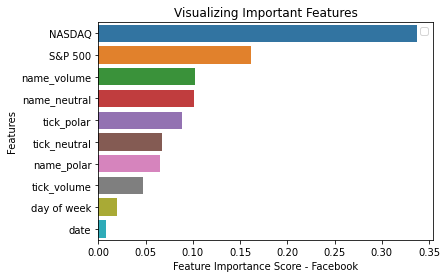

In [60]:
forest = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
forest.fit(X_train, y_train)
# y_pred=forest.predict(X_test)

feature_imp = pd.Series(forest.feature_importances_,index=X_train.columns).sort_values(ascending=False)

# selected_feat= X.columns[(sel.get_support())]


# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score - Facebook')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()